In [179]:
import mysql
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt 
import requests 
import numpy as np 
import cv2 
from io import BytesIO
import os
import glob

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision.models import ResNet50_Weights
import  torch.nn.functional as F

from sklearn.model_selection import train_test_split

import sys
sys.path.append('/Users/anhyojun/WorkSpace/KDT2/MyModule')
from KDTModule import *

In [180]:
torch.manual_seed(1)

In [181]:
# csv -> DataFrame 변환
df = pd.read_csv('movieDF.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29707 entries, 0 to 29706
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            29707 non-null  int64  
 1   ko_name       29707 non-null  object 
 2   en_name       29281 non-null  object 
 3   year          29701 non-null  float64
 4   country       29707 non-null  object 
 5   grade         19819 non-null  object 
 6   genre         29707 non-null  object 
 7   runtime       29706 non-null  float64
 8   release_date  14302 non-null  object 
 9   audience      12299 non-null  float64
 10  director      29625 non-null  object 
 11  story         27062 non-null  object 
 12  poster_link   29707 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 2.9+ MB


In [182]:
# 장르 종류 리스트화
genre = df['genre']

genre_columns = set()
for i in genre:
    split_list = i.split(', ')
    for j in split_list:
        genre_columns.add(j)

genre_list = list(genre_columns)

# 장르 종류 개수
print(len(genre_list))
print(genre_list)

41
['시대극', '판타지', '느와르', '옴니버스', '자연재해', '추리', '어드벤처', '스파이', '단편 영화', '3D', '드라마', '실험영화', '뮤직', 'TV 시리즈', '미스터리', '멜로·로맨스', '가족', '코미디', '블록버스터', '전기', '범죄', '공포', '애니메이션', '서스펜스', '무협', '모험', '역사·서사', '흑백 영화', '실화', '다큐멘터리', '전쟁', '액션', 'SF', '시트콤', '뮤지컬', '무성 영화', '스릴러', '퀴어', '스포츠', '서부', '복수']


In [183]:
# 다중 레이블 장르 원-핫 인코딩
total_one_hot_list = []
for i in genre:
    split_list = i.split(', ')
    one_hot_list = [0] * len(genre_list)
    for j in split_list:
        for index, value in enumerate(genre_list):
            if j == value:
                one_hot_list[index] += 1
    total_one_hot_list.append(one_hot_list)

In [184]:
target_one_hot = pd.DataFrame(total_one_hot_list, columns=genre_list)
target_one_hot.head()

,시대극,판타지,느와르,옴니버스,자연재해,추리,어드벤처,스파이,단편 영화,3D,...,액션,SF,시트콤,뮤지컬,무성 영화,스릴러,퀴어,스포츠,서부,복수
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
# 장르별 빈도수 확인
print(target_one_hot.sum(axis=0))

시대극          85
판타지        1225
느와르         169
옴니버스         76
자연재해         11
추리           13
어드벤처        254
스파이           2
단편 영화       313
3D           46
드라마       13985
실험영화         10
뮤직          305
TV 시리즈        3
미스터리       1259
멜로·로맨스     3781
가족          493
코미디        5927
블록버스터       155
전기           57
범죄         3722
공포         2206
애니메이션      1881
서스펜스          9
무협          253
모험            6
역사·서사        83
흑백 영화        24
실화           23
다큐멘터리      1863
전쟁          763
액션         5053
SF         1393
시트콤           1
뮤지컬         388
무성 영화         5
스릴러        2783
퀴어           17
스포츠          84
서부          214
복수            1
dtype: int64


빈도수가 너무 적은 장르들이 많다

In [186]:
# 빈도수가 적은 장르 '그 외'로 통합
cols = ['단편 영화', '모험', '어드벤처', '옴니버스', '흑백 영화', '실화', '블록버스터',
        '무성 영화', '퀴어', '자연재해', '역사·서사', '서스펜스', '스파이', '서부', '뮤지컬',
        '시트콤', '느와르', '실험영화', '추리', '복수', 'TV 시리즈', '가족', '3D', '시대극', 
        '뮤직', '스포츠', '전기', '무협']
target_one_hot['그 외'] = [1 if i >= 1 else 0 for i in target_one_hot[cols].sum(axis=1)]
target_one_hot_scaled = target_one_hot.drop(cols, axis=1)
target_one_hot_scaled['id'] = df['id']
target_one_hot_scaled

,판타지,드라마,미스터리,멜로·로맨스,코미디,범죄,공포,애니메이션,다큐멘터리,전쟁,액션,SF,스릴러,그 외,id
0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1
1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,2
2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,3
3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,4
4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29702,0,0,0,0,0,0,0,0,1,0,0,0,0,1,61822
29703,0,1,0,1,0,0,0,0,0,0,0,0,0,0,61823
29704,0,0,0,0,0,0,0,0,1,0,0,0,0,0,61824
29705,0,1,0,0,0,0,0,0,0,0,0,0,0,0,61826


In [187]:
target_one_hot_scaled[target_one_hot_scaled['드라마'] == 2]

,판타지,드라마,미스터리,멜로·로맨스,코미디,범죄,공포,애니메이션,다큐멘터리,전쟁,액션,SF,스릴러,그 외,id
6084,0,2,0,0,0,0,0,0,0,0,0,0,0,0,12094
16729,0,2,0,0,0,0,0,0,0,0,0,0,0,0,38643
20434,0,2,0,0,0,0,0,0,0,0,0,0,0,0,46577


아놔... 빈도가 2 이상인 장르가 있다... 홈페이지를 보니 실수를 한 것 같다... (드라마, 드라마) 이런 식으로 적어놨는데 제기랄...

In [188]:
for i in target_one_hot_scaled.columns[:-1]:
    target_one_hot_scaled[i] = [1 if i >= 1 else 0 for i in target_one_hot_scaled[i]]

for i in target_one_hot_scaled.columns[:-1]:
    print(target_one_hot_scaled[i].value_counts())

판타지
0    28482
1     1225
Name: count, dtype: int64
드라마
0    15725
1    13982
Name: count, dtype: int64
미스터리
0    28449
1     1258
Name: count, dtype: int64
멜로·로맨스
0    25926
1     3781
Name: count, dtype: int64
코미디
0    23781
1     5926
Name: count, dtype: int64
범죄
0    25988
1     3719
Name: count, dtype: int64
공포
0    27501
1     2206
Name: count, dtype: int64
애니메이션
0    27828
1     1879
Name: count, dtype: int64
다큐멘터리
0    27844
1     1863
Name: count, dtype: int64
전쟁
0    28944
1      763
Name: count, dtype: int64
액션
0    24657
1     5050
Name: count, dtype: int64
SF
0    28314
1     1393
Name: count, dtype: int64
스릴러
0    26925
1     2782
Name: count, dtype: int64
그 외
0    26762
1     2945
Name: count, dtype: int64


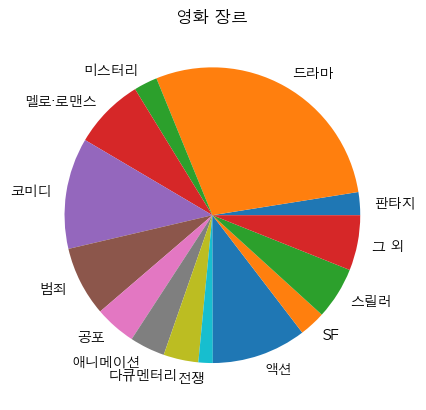

In [189]:
value = target_one_hot_scaled.drop('id', axis=1).sum(axis=0)
plt.rc('font', family='AppleGothic')
plt.pie(value, labels=value.index)
plt.title('영화 장르')
plt.show()

드라마 장르가 너무 많다

In [190]:
# 드라마 제외한 장르 선택 후 중강
no_drama = target_one_hot_scaled[target_one_hot_scaled['드라마'] == 0]
total_target = pd.concat([target_one_hot_scaled, no_drama, no_drama, no_drama], axis=0).drop('id', axis=1)
total_target.sum(axis=0)

판타지        3868
드라마       13982
미스터리       3805
멜로·로맨스     9370
코미디       17959
범죄        10301
공포         8173
애니메이션      7150
다큐멘터리      7170
전쟁         1543
액션        16867
SF         4957
스릴러        9490
그 외        8915
dtype: int64

In [191]:
total_target

,판타지,드라마,미스터리,멜로·로맨스,코미디,범죄,공포,애니메이션,다큐멘터리,전쟁,액션,SF,스릴러,그 외
0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2,0,0,0,1,1,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29698,0,0,0,0,0,0,0,0,0,0,0,0,0,1
29699,0,0,0,0,0,0,0,0,0,1,1,0,0,0
29700,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29702,0,0,0,0,0,0,0,0,1,0,0,0,0,1


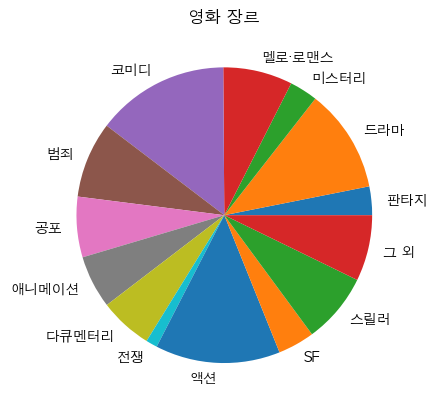

In [192]:
value = total_target.sum(axis=0)
plt.rc('font', family='AppleGothic')
plt.pie(value, labels=value.index)
plt.title('영화 장르')
plt.show()

아직 불균형이 존재하긴 하지만 이전에 비해서는 개선되었다

In [193]:
# 포스터 저장
# idx = 0
# poster_link = df['poster_link'][idx:]
# for index, link in enumerate(poster_link):
#     response = requests.get(link)
#     img = Image.open(BytesIO(response.content))
#     RGB_img = img.convert('RGB')
#     id = df['id'][index+idx]
#     safe_name = df['ko_name'][index+idx].replace('/', ' ')
#     RGB_img.save(f"/Users/anhyojun/WorkSpace/LocalData/영화 포스터/{id}_{safe_name}.jpg")

In [194]:
# # 이미지 90, 180, 270도 회전 증강
# no_drama_id = target_one_hot_scaled[target_one_hot_scaled['드라마'] == 0]['id']
# poster_path = '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/'

# for angle in [90, 180, 270]:
#     for id in no_drama_id.values:
#         name = df[df['id'] == id]['ko_name'].iloc[0].replace('/', ' ')
#         img = Image.open(f"{poster_path}{id}_{name}.jpg")
#         rotate_img = img.rotate(angle, expand=True)
#         save_path = f'/Users/anhyojun/WorkSpace/LocalData/영화 포스터 회전{angle}/{id}_{name}_{angle}.jpg'
#         rotate_img.save(save_path)

In [195]:
# 이미지 폴더 경로
poster_path = '/Users/anhyojun/WorkSpace/LocalData/영화 포스터'
poster_path_90 = '/Users/anhyojun/WorkSpace/LocalData/영화 포스터 회전90'
poster_path_180 = '/Users/anhyojun/WorkSpace/LocalData/영화 포스터 회전180'
poster_path_270 = '/Users/anhyojun/WorkSpace/LocalData/영화 포스터 회전270'

# 폴더 리스트
poster_paths = [poster_path, poster_path_90, poster_path_180, poster_path_270]

In [196]:
all_poster_path = []

for path in poster_paths:
    path_list = glob.glob(f"{path}/*.jpg")
    sorted_path = sorted(path_list, key=lambda x : int(x.split('_')[0].split('/')[-1]))
    all_poster_path.extend(sorted_path)

In [197]:
all_poster_path

['/Users/anhyojun/WorkSpace/LocalData/영화 포스터/1_히트.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/2_랜섬.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/3_귀여운 여인.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/4_라스베가스를 떠나며.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/5_보디가드.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/6_고양이와 개에 관한 진실.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/7_아기공룡 둘리: 얼음별 대모험 리마스터링.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/8_인형의 집으로 오세요.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/9_인디펜던스 데이.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/10_나의 성생활: 나는 어떻게 싸웠는가.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/11_마이클 콜린스.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/12_트레인스포팅.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/13_센스 앤 센서빌리티.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/14_공각기동대.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/15_동궁서궁.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/17_율리시즈의 시

In [198]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labelsDF, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.labels = np.array(labelsDF)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            input_tensor = self.transform(image)

        label_tensor = torch.tensor(label, dtype=torch.float)

        return input_tensor, label_tensor

In [199]:
train_path, test_path, train_label, test_label = train_test_split(all_poster_path, total_target,
                                                                  test_size = 0.2, random_state = 42)
train_path, valid_path, train_label, valid_label = train_test_split(train_path, train_label,
                                                                    test_size = 0.2, random_state = 42)
print(f"train_label.shape {train_label.shape}")
print(f"valid_label.shape {valid_label.shape}")
print(f"test_label.shape {test_label.shape}")

train_label.shape (49204, 14)
valid_label.shape (12301, 14)
test_label.shape (15377, 14)


In [200]:
# 이미지 전처리(transform) 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 정규화 값
])

trainDS = CustomImageDataset(train_path, train_label, transform)
validDS = CustomImageDataset(valid_path, valid_label, transform)
testDS = CustomImageDataset(test_path, test_label, transform)

In [201]:
trainDL = DataLoader(trainDS, batch_size=32, shuffle=True)
validDL = DataLoader(validDS, batch_size=32, shuffle=True)
testDL = DataLoader(testDS, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


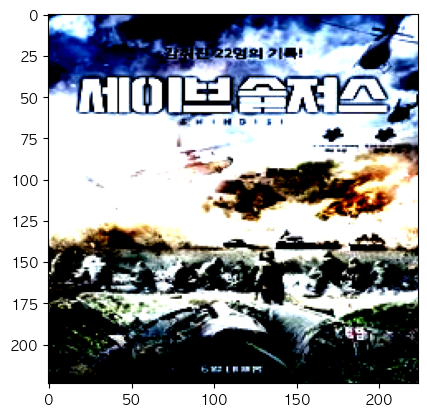

In [202]:
plt.imshow(trainDL.dataset[9][0].permute(1,2,0))
plt.show()

In [203]:
# 미리 학습된 ResNet 모델 불러오기 (weight 사용)
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.fc.parameters():
    param.requires_grad = True

In [204]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [205]:
# 마지막 레이어 (full connected layer) 교체 (클래스 5개로 변경)
num_features = model.fc.in_features # 2048
model.fc = nn.Linear(num_features, 14) # 입력은 이전 층의 아웃을 그대로 받고 출력은 방법대 인원

In [206]:
# MPS 사용 여부 확인하기
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"device : {device}")

device : mps


In [207]:
# 훈련
EPOCH = 100
SAVE_PATH = '/Users/anhyojun/WorkSpace/KDT2/김소현 강사님/프로젝트/개인 프로젝트/ResNet50'

# 옵티마이저를 모델 파라미터에 대해 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

result = training(trainDL, validDL, model, model_type = 'multilabel', optimizer = optimizer,
                  epoch = EPOCH, endurance_cnt = 5, view_epoch = 1, num_classes = 14, SAVE_PATH = SAVE_PATH,
                  MPS = True, device = device)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/envs/TORCH_TEXT_38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/ld/7fj1069x6q7fr5894rwywdk40000gn/T/ipykernel_5134/1681170545.py", line 8, in <module>
    result = training(trainDL, validDL, model, model_type = 'multilabel', optimizer = optimizer,
  File "/Users/anhyojun/WorkSpace/KDT2/MyModule/KDTModule.py", line 370, in training
UnboundLocalError: local variable 'loss_test_avg' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/TORCH_TEXT_38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/opt/anaconda3/envs/TORCH_TEXT_38/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1396, in structured_trac